# 3 Preprocessing and Training

In this notebook we will train different time series machine learning models starting from classical time series models such as AR, MA, ARIMA etc moving to more advanced deep learning models such as LSTM, DEEPAR and specialized packages such as fbprophet and kats for two different wells. The first well has the production profile of a typical decline curve and the second well does not. 

 <b>3.1 Import Relevant Package <b/>

In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from operator import itemgetter
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.model_selection import TimeSeriesSplit

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

 <b>3.2 Import CSV <b/>

In [3]:
df = pd.read_csv('Monthly.csv')

 <b>3.3 Examine Data <b/>

Call head of data

In [4]:
df.head()

,level_0,index,DATEPRD,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,NPD_WELL_BORE_NAME,AVG_DOWNHOLE_PRESSURE.shifted3,AVG_DOWNHOLE_TEMPERATURE.shifted3,AVG_DP_TUBING.shifted3,AVG_ANNULUS_PRESS.shifted3,AVG_CHOKE_SIZE_P.shifted3,AVG_WHP_P.shifted3,AVG_WHT_P.shifted3,DP_CHOKE_SIZE.shifted3,BORE_OIL_VOL.shifted3,BORE_GAS_VOL.shifted3,BORE_WAT_VOL.shifted3,BORE_WI_VOL.shifted3
0,3,3,2014-07-01,215.305839,108.150677,166.458710,0.0,47.269826,48.847129,56.742968,20.381968,15084.0,0.0,6244.0,0.0,15/9-F-1 C,265.236380,98.164455,211.228320,0.0,22.489461,47.242292,27.762750,34.311375,631.0,0.0,0.0,0.0
1,4,4,2014-08-01,230.622097,105.879581,188.180742,0.0,29.241656,42.441258,41.679613,24.964645,6968.0,0.0,4530.0,0.0,15/9-F-1 C,223.846688,107.821219,156.003875,0.0,46.411330,67.842750,55.589875,39.336469,21293.0,0.0,863.0,0.0
2,5,5,2014-09-01,229.762933,107.569067,188.690067,0.0,43.583238,41.072900,53.928133,15.410067,9170.0,0.0,8318.0,0.0,15/9-F-1 C,217.370621,108.005379,157.585724,0.0,46.633436,59.784828,56.344345,31.480724,18893.0,0.0,1989.0,0.0
3,6,6,2014-10-01,220.280879,108.347424,184.229091,0.0,51.007502,36.051788,54.949455,8.193061,10102.0,0.0,11021.0,0.0,15/9-F-1 C,215.305839,108.150677,166.458710,0.0,47.269826,48.847129,56.742968,20.381968,15084.0,0.0,6244.0,0.0
4,7,7,2014-11-03,228.134321,107.203750,190.050214,0.0,40.942230,38.083929,47.676036,15.755357,6071.0,251.0,6582.0,0.0,15/9-F-1 C,230.622097,105.879581,188.180742,0.0,29.241656,42.441258,41.679613,24.964645,6968.0,0.0,4530.0,0.0


Call columns of dataframe

In [5]:
df.columns

Index(['level_0', 'index', 'DATEPRD', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE',
       'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'BORE_WI_VOL',
       'NPD_WELL_BORE_NAME', 'AVG_DOWNHOLE_PRESSURE.shifted3',
       'AVG_DOWNHOLE_TEMPERATURE.shifted3', 'AVG_DP_TUBING.shifted3',
       'AVG_ANNULUS_PRESS.shifted3', 'AVG_CHOKE_SIZE_P.shifted3',
       'AVG_WHP_P.shifted3', 'AVG_WHT_P.shifted3', 'DP_CHOKE_SIZE.shifted3',
       'BORE_OIL_VOL.shifted3', 'BORE_GAS_VOL.shifted3',
       'BORE_WAT_VOL.shifted3', 'BORE_WI_VOL.shifted3'],
      dtype='object')

Find unique wells in 'NPD_WELL_BORE_NAME' column.

In [6]:
df['NPD_WELL_BORE_NAME'].unique()

array(['15/9-F-1 C', '15/9-F-11', '15/9-F-12', '15/9-F-14', '15/9-F-15 D'],
      dtype=object)

 <b>3.4 Preprocessing and training for well with a typical decline curve profile<b/>

From the previous notebook we can see that well F-14 follows a typical decline curve thus we will use this as the first well for modelling. 

In [7]:
df1 = df[df['NPD_WELL_BORE_NAME'] =='15/9-F-14'].copy()

Examine head of data

In [8]:
df1.head()

,level_0,index,DATEPRD,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,NPD_WELL_BORE_NAME,AVG_DOWNHOLE_PRESSURE.shifted3,AVG_DOWNHOLE_TEMPERATURE.shifted3,AVG_DP_TUBING.shifted3,AVG_ANNULUS_PRESS.shifted3,AVG_CHOKE_SIZE_P.shifted3,AVG_WHP_P.shifted3,AVG_WHT_P.shifted3,DP_CHOKE_SIZE.shifted3,BORE_OIL_VOL.shifted3,BORE_GAS_VOL.shifted3,BORE_WAT_VOL.shifted3,BORE_WI_VOL.shifted3
158,171,3,2008-05-01,14.214750,2.319313,14.214750,0.000000,63.175792,0.000000,0.000000,28.645469,0.0,0.0,0.0,0.0,15/9-F-14,0.000000,0.000000,0.000000,0.000100,67.387511,0.000000,0.000000,2.271700,0.0,0.0,0.0,0.0
159,172,4,2008-06-02,5.186621,1.834414,5.186621,0.000000,62.740097,0.000000,0.000000,20.920310,0.0,0.0,0.0,0.0,15/9-F-14,0.000000,0.000000,0.000000,0.001931,65.063804,0.000000,0.001517,20.123034,0.0,0.0,0.0,0.0
160,173,5,2008-07-01,255.998355,100.452387,191.579903,4.273996,44.367193,64.418452,50.857258,45.400065,592.0,0.0,122.0,0.0,15/9-F-14,7.769155,3.171126,6.421770,0.350933,65.141261,1.384353,2.570101,26.050425,0.0,0.0,0.0,0.0
161,174,6,2008-08-01,249.399021,102.608122,180.185938,8.490311,41.985713,69.248955,58.543098,46.706218,1636.0,0.0,223.0,0.0,15/9-F-14,14.214750,2.319313,14.214750,0.000000,63.175792,0.000000,0.000000,28.645469,0.0,0.0,0.0,0.0
162,175,7,2008-09-01,231.776500,104.511867,159.157467,8.422388,43.718179,72.618967,72.336033,40.767267,0.0,0.0,276.0,0.0,15/9-F-14,5.186621,1.834414,5.186621,0.000000,62.740097,0.000000,0.000000,20.920310,0.0,0.0,0.0,0.0


Drop 'index' and 'level_0' columns from df1 

In [9]:
df1.drop(columns=['index','level_0'], inplace=True)

Reset index of dataframe

In [10]:
df1.reset_index(inplace=True)

Examine head of dataframe

In [11]:
df1.head()

,index,DATEPRD,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,NPD_WELL_BORE_NAME,AVG_DOWNHOLE_PRESSURE.shifted3,AVG_DOWNHOLE_TEMPERATURE.shifted3,AVG_DP_TUBING.shifted3,AVG_ANNULUS_PRESS.shifted3,AVG_CHOKE_SIZE_P.shifted3,AVG_WHP_P.shifted3,AVG_WHT_P.shifted3,DP_CHOKE_SIZE.shifted3,BORE_OIL_VOL.shifted3,BORE_GAS_VOL.shifted3,BORE_WAT_VOL.shifted3,BORE_WI_VOL.shifted3
0,158,2008-05-01,14.214750,2.319313,14.214750,0.000000,63.175792,0.000000,0.000000,28.645469,0.0,0.0,0.0,0.0,15/9-F-14,0.000000,0.000000,0.000000,0.000100,67.387511,0.000000,0.000000,2.271700,0.0,0.0,0.0,0.0
1,159,2008-06-02,5.186621,1.834414,5.186621,0.000000,62.740097,0.000000,0.000000,20.920310,0.0,0.0,0.0,0.0,15/9-F-14,0.000000,0.000000,0.000000,0.001931,65.063804,0.000000,0.001517,20.123034,0.0,0.0,0.0,0.0
2,160,2008-07-01,255.998355,100.452387,191.579903,4.273996,44.367193,64.418452,50.857258,45.400065,592.0,0.0,122.0,0.0,15/9-F-14,7.769155,3.171126,6.421770,0.350933,65.141261,1.384353,2.570101,26.050425,0.0,0.0,0.0,0.0
3,161,2008-08-01,249.399021,102.608122,180.185938,8.490311,41.985713,69.248955,58.543098,46.706218,1636.0,0.0,223.0,0.0,15/9-F-14,14.214750,2.319313,14.214750,0.000000,63.175792,0.000000,0.000000,28.645469,0.0,0.0,0.0,0.0
4,162,2008-09-01,231.776500,104.511867,159.157467,8.422388,43.718179,72.618967,72.336033,40.767267,0.0,0.0,276.0,0.0,15/9-F-14,5.186621,1.834414,5.186621,0.000000,62.740097,0.000000,0.000000,20.920310,0.0,0.0,0.0,0.0


Drop index column

In [12]:
df1.drop(columns=['index'], inplace=True)

Set 'DATEPRD' column as index.

In [13]:
df1.set_index('DATEPRD',inplace=True)

Convert index as datetime

In [14]:
df1.index = pd.to_datetime(df1.index)

Find datatypes for each column

In [15]:
df1.dtypes

AVG_DOWNHOLE_PRESSURE                float64
AVG_DOWNHOLE_TEMPERATURE             float64
AVG_DP_TUBING                        float64
AVG_ANNULUS_PRESS                    float64
AVG_CHOKE_SIZE_P                     float64
AVG_WHP_P                            float64
AVG_WHT_P                            float64
DP_CHOKE_SIZE                        float64
BORE_OIL_VOL                         float64
BORE_GAS_VOL                         float64
BORE_WAT_VOL                         float64
BORE_WI_VOL                          float64
NPD_WELL_BORE_NAME                    object
AVG_DOWNHOLE_PRESSURE.shifted3       float64
AVG_DOWNHOLE_TEMPERATURE.shifted3    float64
AVG_DP_TUBING.shifted3               float64
AVG_ANNULUS_PRESS.shifted3           float64
AVG_CHOKE_SIZE_P.shifted3            float64
AVG_WHP_P.shifted3                   float64
AVG_WHT_P.shifted3                   float64
DP_CHOKE_SIZE.shifted3               float64
BORE_OIL_VOL.shifted3                float64
BORE_GAS_V

Examine head of dataframe

In [16]:
df1.head()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,NPD_WELL_BORE_NAME,AVG_DOWNHOLE_PRESSURE.shifted3,AVG_DOWNHOLE_TEMPERATURE.shifted3,AVG_DP_TUBING.shifted3,AVG_ANNULUS_PRESS.shifted3,AVG_CHOKE_SIZE_P.shifted3,AVG_WHP_P.shifted3,AVG_WHT_P.shifted3,DP_CHOKE_SIZE.shifted3,BORE_OIL_VOL.shifted3,BORE_GAS_VOL.shifted3,BORE_WAT_VOL.shifted3,BORE_WI_VOL.shifted3
DATEPRD,,,,,,,,,,,,,,,,,,,,,,,,,
2008-05-01,14.214750,2.319313,14.214750,0.000000,63.175792,0.000000,0.000000,28.645469,0.0,0.0,0.0,0.0,15/9-F-14,0.000000,0.000000,0.000000,0.000100,67.387511,0.000000,0.000000,2.271700,0.0,0.0,0.0,0.0
2008-06-02,5.186621,1.834414,5.186621,0.000000,62.740097,0.000000,0.000000,20.920310,0.0,0.0,0.0,0.0,15/9-F-14,0.000000,0.000000,0.000000,0.001931,65.063804,0.000000,0.001517,20.123034,0.0,0.0,0.0,0.0
2008-07-01,255.998355,100.452387,191.579903,4.273996,44.367193,64.418452,50.857258,45.400065,592.0,0.0,122.0,0.0,15/9-F-14,7.769155,3.171126,6.421770,0.350933,65.141261,1.384353,2.570101,26.050425,0.0,0.0,0.0,0.0
2008-08-01,249.399021,102.608122,180.185938,8.490311,41.985713,69.248955,58.543098,46.706218,1636.0,0.0,223.0,0.0,15/9-F-14,14.214750,2.319313,14.214750,0.000000,63.175792,0.000000,0.000000,28.645469,0.0,0.0,0.0,0.0
2008-09-01,231.776500,104.511867,159.157467,8.422388,43.718179,72.618967,72.336033,40.767267,0.0,0.0,276.0,0.0,15/9-F-14,5.186621,1.834414,5.186621,0.000000,62.740097,0.000000,0.000000,20.920310,0.0,0.0,0.0,0.0


Create list from column names

In [17]:
items_list = list(df1.columns)

Create list of columns that we are not including in modelling

In [18]:
list_to_remove = ['AVG_DOWNHOLE_PRESSURE.shifted3',
 'AVG_DOWNHOLE_TEMPERATURE.shifted3',
 'AVG_DP_TUBING.shifted3',
 'AVG_ANNULUS_PRESS.shifted3',
 'AVG_CHOKE_SIZE_P.shifted3',
 'AVG_WHP_P.shifted3',
 'AVG_WHT_P.shifted3',
 'DP_CHOKE_SIZE.shifted3',
 'BORE_OIL_VOL.shifted3',
 'BORE_GAS_VOL.shifted3',
 'BORE_WAT_VOL.shifted3',
 'BORE_WI_VOL.shifted3','NPD_WELL_BORE_NAME','BORE_WI_VOL']

Drop irrelevant columns

In [19]:
df1.drop(columns=list_to_remove,inplace=True)

Create final list of columns to be included in modelling

In [20]:
columnlist = list(set(items_list)-set(list_to_remove))

In [21]:
columnlist

['AVG_ANNULUS_PRESS',
 'BORE_OIL_VOL',
 'AVG_DOWNHOLE_PRESSURE',
 'BORE_WAT_VOL',
 'AVG_WHP_P',
 'BORE_GAS_VOL',
 'AVG_DOWNHOLE_TEMPERATURE',
 'AVG_CHOKE_SIZE_P',
 'AVG_DP_TUBING',
 'DP_CHOKE_SIZE',
 'AVG_WHT_P']

Find correlation between target variable and each feature

In [22]:
for element in columnlist:
    print( element , df1['BORE_OIL_VOL'].corr(df1[element]))

AVG_ANNULUS_PRESS 0.7124373834184683
BORE_OIL_VOL 1.0
AVG_DOWNHOLE_PRESSURE 0.1913455602229185
BORE_WAT_VOL -0.1672047589562501
AVG_WHP_P -0.4044588109721314
BORE_GAS_VOL 0.1997872648975512
AVG_DOWNHOLE_TEMPERATURE 0.037926181667197606
AVG_CHOKE_SIZE_P 0.5320877334934611
AVG_DP_TUBING 0.36350973016797383
DP_CHOKE_SIZE -0.48210812924238944
AVG_WHT_P 0.24553624759225262


Remove irrelevant data

In [23]:
df1= df1[df1.index >= '2013-02-01'].copy()

Plot ACF to examine weather oil production time series is stationary.

Zero-differencing

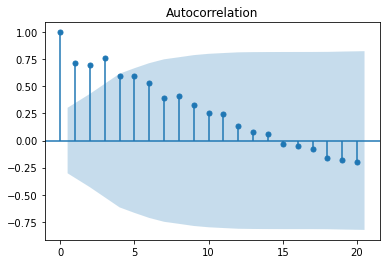

In [24]:
plot_acf(df1['BORE_OIL_VOL'], lags= 20, alpha=0.05);

From the plot we can see that the time series is not stationary

Call adfuller function on time series

In [25]:
adfuller(df1['BORE_OIL_VOL'])

(-3.0565216560614554,
 0.029942619436304975,
 5,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 514.4717450780674)

Based on the adf test we can tell that the time series is not stationary.

1st-Order Differencing

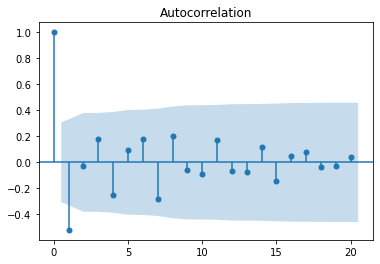

In [26]:
plot_acf(df1['BORE_OIL_VOL'].diff().dropna(), lags= 20, alpha=0.05);

From the ACF the 1st-Order differencing makes the time series look stationary.

Call the ADF on the first order difference

In [27]:
adfuller(df1['BORE_OIL_VOL'].diff().dropna())

(-2.4491243641201876,
 0.12834851119668744,
 5,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 501.59829364936394)

The time series is still not stationary we will do a second order differencing

2nd-Order Differencing

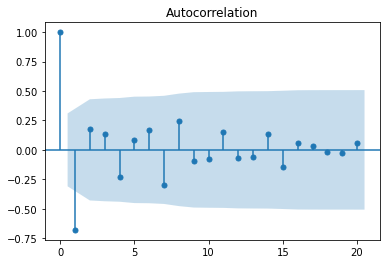

In [28]:
plot_acf(df1['BORE_OIL_VOL'].diff().diff().dropna(), lags= 20, alpha=0.05);

Call the ADF on the second order difference

In [29]:
adfuller(df1['BORE_OIL_VOL'].diff().diff().dropna())

(-4.907848665433435,
 3.3668107989803735e-05,
 9,
 30,
 {'1%': -3.6699197407407405,
  '5%': -2.9640707407407407,
  '10%': -2.621171111111111},
 485.9887832271845)

From the ADF test we can see that 2nd-Order differencing makes the time series stationary.

Split data Train/Test datasets

In [30]:
df.tail(5)

,level_0,index,DATEPRD,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,NPD_WELL_BORE_NAME,AVG_DOWNHOLE_PRESSURE.shifted3,AVG_DOWNHOLE_TEMPERATURE.shifted3,AVG_DP_TUBING.shifted3,AVG_ANNULUS_PRESS.shifted3,AVG_CHOKE_SIZE_P.shifted3,AVG_WHP_P.shifted3,AVG_WHT_P.shifted3,DP_CHOKE_SIZE.shifted3,BORE_OIL_VOL.shifted3,BORE_GAS_VOL.shifted3,BORE_WAT_VOL.shifted3,BORE_WI_VOL.shifted3
280,298,26,2016-03-01,218.160839,105.842548,184.348968,16.219032,12.305040,33.811903,37.630516,17.960387,3746.0,0.0,5035.0,0.0,15/9-F-15 D,235.947839,105.421000,185.107484,14.387484,14.314489,50.840452,33.618452,27.186484,4919.0,0.0,5075.0,0.0
281,299,27,2016-04-01,232.322097,105.748387,197.699839,16.777710,19.452198,34.622387,36.326290,11.161452,4632.0,29.0,5787.0,0.0,15/9-F-15 D,248.310581,104.530258,182.735355,10.683419,8.756012,65.575129,22.690419,45.526226,2889.0,0.0,3648.0,0.0
282,300,28,2016-05-02,209.074633,106.246333,184.315067,18.663567,15.825980,24.759633,42.437867,8.121633,4609.0,0.0,5907.0,0.0,15/9-F-15 D,206.301759,106.502345,181.795828,20.294241,13.548147,24.505897,43.399517,8.508448,5112.0,0.0,5892.0,0.0
283,301,29,2016-06-01,212.926967,105.923067,184.994100,16.132400,23.024772,27.932900,40.764933,14.086767,3466.0,0.0,5390.0,0.0,15/9-F-15 D,218.160839,105.842548,184.348968,16.219032,12.305040,33.811903,37.630516,17.960387,3746.0,0.0,5035.0,0.0
284,302,30,2016-07-01,308.101258,92.706710,299.597355,4.271226,7.057121,8.503903,12.570806,9.004000,828.0,0.0,1173.0,0.0,15/9-F-15 D,232.322097,105.748387,197.699839,16.777710,19.452198,34.622387,36.326290,11.161452,4632.0,29.0,5787.0,0.0


In [31]:
Train=df1.loc[:'2016-03-01']

In [32]:
Test=df1.loc['2016-04-01':]

The last 4 months will serve as the test set

 <b>3.4.1 AR model<b/>

Create an AR model of order P=5 and D=2 based on the ACF and ADF tests.

In [33]:
ARIMA_model1 = ARIMA(Train['BORE_OIL_VOL'], order=(5,2,0))

Fit data to model

In [34]:
result = ARIMA_model1.fit()

Print summary results

In [35]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:           BORE_OIL_VOL   No. Observations:                   38
Model:                 ARIMA(5, 2, 0)   Log Likelihood                -344.970
Date:                Mon, 21 Feb 2022   AIC                            701.939
Time:                        15:22:41   BIC                            711.440
Sample:                    02-01-2013   HQIC                           705.255
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3648      0.322     -4.236      0.000      -1.996      -0.733
ar.L2         -1.5997      0.514     -3.112      0.002      -2.607      -0.592
ar.L3         -1.0681      0.748     -1.428      0.1

The first model has an AIC score of 701 and BIC score of 711.

Try different combinations of p and d to find the best AR model.

Calculate and plot BIC for each model

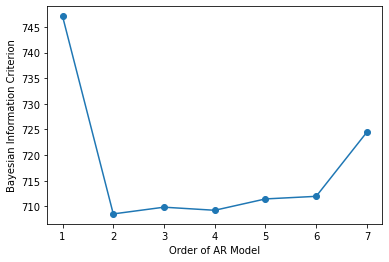

In [36]:
BIC = np.zeros(8)
for p in range(8):
    mod = ARIMA(Train['BORE_OIL_VOL'], order=(p,2,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,8), BIC[1:8], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

Calculate and plot AIC for each model

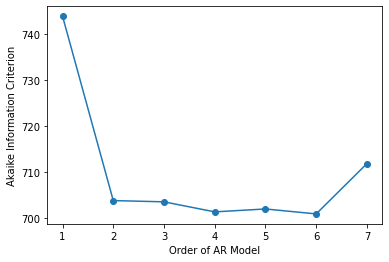

In [37]:
AIC = np.zeros(8)
for p in range(8):
    mod = ARIMA(Train['BORE_OIL_VOL'], order=(p,2,0))
    res = mod.fit()
# Save BIC for AR(p)    
    AIC[p] = res.aic
    
# Plot the aiC as a function of p
plt.plot(range(1,8), AIC[1:8], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()

The best model is the model with p=2 and d=2

In [38]:
mod = ARIMA(Train['BORE_OIL_VOL'], order=(2,2,0))
result = mod.fit()

Predict last 4 months of oil production

In [39]:
result.predict(start='2016-04-01',end='2016-07-01')

2016-04-01    3206.747899
2016-05-02    2660.280297
2016-06-01    2363.190454
2016-07-01    1834.338335
Freq: BMS, Name: predicted_mean, dtype: float64

Create dataframe that will accumalete predictions of different models

In [40]:
Summary =pd.DataFrame(Test['BORE_OIL_VOL'])

Save best AR model to Summary dataframe

In [41]:
Summary['AR_order_2_difference_2']=result.predict(start='2016-04-01',end='2016-07-01')

Since the AIC score for the model with order p=6 and d=2 is lower than the model with the lowest BIC model we will also use the former model for comparison with other models.

In [42]:
mod = ARIMA(Train['BORE_OIL_VOL'], order=(6,2,0))
result = mod.fit()

Predict last 4 months of oil production

In [43]:
result.predict(start='2016-04-01',end='2016-07-01')

2016-04-01    2993.461587
2016-05-02    2251.884310
2016-06-01    1980.618482
2016-07-01    1260.698606
Freq: BMS, Name: predicted_mean, dtype: float64

Add model result to summary

In [44]:
Summary['AR_order_6_difference_2']=result.predict(start='2016-04-01',end='2016-07-01')

Checking the summary table so far we have the predictions for the two AR models

In [45]:
Summary

,BORE_OIL_VOL,AR_order_2_difference_2,AR_order_6_difference_2
DATEPRD,,,
2016-04-01,3212.0,3206.747899,2993.461587
2016-05-02,3116.0,2660.280297,2251.884310
2016-06-01,3073.0,2363.190454,1980.618482
2016-07-01,1326.0,1834.338335,1260.698606


 <b>3.4.2 MA Model<b/>

Look for the best MA model

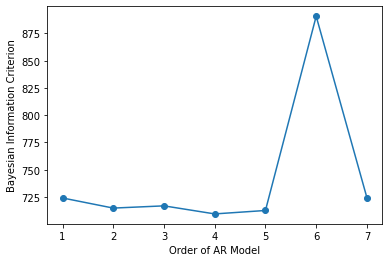

In [46]:
BIC = np.zeros(8)
for p in range(8):
    mod = ARIMA(Train['BORE_OIL_VOL'], order=(0,2,p))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,8), BIC[1:8], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

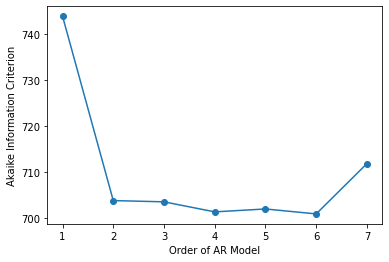

In [47]:
AIC = np.zeros(8)
for p in range(8):
    mod = ARIMA(Train['BORE_OIL_VOL'], order=(p,2,0))
    res = mod.fit()
# Save BIC for AR(p)    
    AIC[p] = res.aic
    
# Plot the aiC as a function of p
plt.plot(range(1,8), AIC[1:8], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()

The best MA models are the ones with d=2 and q=4 and q=6 based on the AIC and BIC scores

Fit MA model d=2 and q=4 to the training set.

In [48]:
mod = ARIMA(Train['BORE_OIL_VOL'], order=(0,2,4))
result = mod.fit()

Print model predictions

In [49]:
result.predict(start='2016-04-01',end='2016-07-01')

2016-04-01    4168.607698
2016-05-02    4241.068482
2016-06-01    4359.796150
2016-07-01    4532.451830
Freq: BMS, Name: predicted_mean, dtype: float64

Save model predictions to Summary dataframe

In [50]:
Summary['MA_order_4_difference_2']=result.predict(start='2016-04-01',end='2016-07-01')

In [51]:
mod = ARIMA(Train['BORE_OIL_VOL'], order=(0,2,6))
result = mod.fit()

Print model predictions

result.predict(start='2016-04-01',end='2016-07-01')

Save predictions to summary dataframe

In [52]:
Summary['MA_order_6_difference_2']=result.predict(start='2016-04-01',end='2016-07-01')

Check Summary dataframe

In [53]:
Summary

,BORE_OIL_VOL,AR_order_2_difference_2,AR_order_6_difference_2,MA_order_4_difference_2,MA_order_6_difference_2
DATEPRD,,,,,
2016-04-01,3212.0,3206.747899,2993.461587,4168.607698,6124.404521
2016-05-02,3116.0,2660.280297,2251.884310,4241.068482,5454.794325
2016-06-01,3073.0,2363.190454,1980.618482,4359.796150,3581.475960
2016-07-01,1326.0,1834.338335,1260.698606,4532.451830,4057.012448


 <b>3.4.3 ARIMA Model<b/>

The ARIMA model is a combination of the AR model and MA model with differencing.

Iterate through different ARIMA models with p from 0 to 6, d=2 and q  from 0 to 6.

In [54]:
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(7):
  # Loop over q values from 0-6
    for q in range(7):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(Train['BORE_OIL_VOL'], order=(p,2,q))
        results = model.fit()        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))
        print(p,q,results.aic, results.bic)

0 0 752.6279463856123 754.2114653240684
0 1 720.9532245835937 724.120262460506
0 2 710.099946398025 714.8505032133934
0 3 710.559918133931 716.8939938877554
0 4 701.5897477583233 709.5073424506038
0 5 703.1562182104793 712.657331841216
0 6 879.6539919875736 890.7386245567664
1 0 743.9142782232926 747.0813161002048
1 1 721.2830344026053 726.0335912179736
1 2 721.0257242124421 727.3597999662666
1 3 704.838176691668 712.7557713839485
1 4 703.1737843802949 712.6748980110316
1 5 717.0627738074702 728.147406376663
1 6 722.3142833332912 734.9824348409401
2 0 703.7656507376864 708.5162075530548
2 1 700.9666671789504 707.3007429327748
2 2 701.3005764483453 709.2181711406258
2 3 711.5230943626307 721.0242079933673
2 4 711.9001056542913 722.9847382234841
2 5 926.2749410490919 938.9430925567408
2 6 862.8593417226102 877.1110121687152
3 0 703.4950229514516 709.829098705276
3 1 702.9284264969051 710.8460211891856
3 2 883.1908214422959 892.6919350730326
3 3 711.4167089150063 722.5013414841991
3 4 832

Order models by AIC score

In [55]:
order_aic_bic_ordered = sorted(order_aic_bic,key=itemgetter(2))

ARIMA p = 6, d = 2, q = 0 has the lowest AIC score

In [56]:
order_aic_bic_ordered

[(6, 0, 700.8623322183396, 711.9469647875324),
 (2, 1, 700.9666671789504, 707.3007429327748),
 (2, 2, 701.3005764483453, 709.2181711406258),
 (4, 0, 701.3081764723007, 709.2257711645813),
 (0, 4, 701.5897477583233, 709.5073424506038),
 (5, 0, 701.9390950381209, 711.4402086688575),
 (4, 1, 702.837993380119, 712.3391070108556),
 (3, 1, 702.9284264969051, 710.8460211891856),
 (0, 5, 703.1562182104793, 712.657331841216),
 (1, 4, 703.1737843802949, 712.6748980110316),
 (3, 0, 703.4950229514516, 709.829098705276),
 (2, 0, 703.7656507376864, 708.5162075530548),
 (1, 3, 704.838176691668, 712.7557713839485),
 (5, 1, 705.1160314791898, 716.2006640483826),
 (6, 1, 705.939804688394, 718.6079561960429),
 (4, 2, 709.9296178214236, 721.0142503906163),
 (0, 2, 710.099946398025, 714.8505032133934),
 (0, 3, 710.559918133931, 716.8939938877554),
 (3, 3, 711.4167089150063, 722.5013414841991),
 (2, 3, 711.5230943626307, 721.0242079933673),
 (2, 4, 711.9001056542913, 722.9847382234841),
 (1, 5, 717.06277380

Fit data to the model

In [57]:
model = SARIMAX(Train['BORE_OIL_VOL'], order=(6,2,0),initialization='approximate_diffuse')
result = model.fit()

Save model predictions to Summary dataframe

In [58]:
Summary['ARIMA_p_order_6_difference_2_q_order_0']=result.predict(start='2016-04-01',end='2016-07-01')

 <b>3.4.4 ARIMAX Model<b/>

ARIMAX models are ARIMA models with the exogeneous variables. 

Iterate through different ARIMAX models with p from 0 to 6, d=2 and q from 0 to 6.

In [59]:
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(7):
  # Loop over q values from 0-6
    for q in range(7):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(Train['BORE_OIL_VOL'], order=(p,2,q),exog=Train[['AVG_DOWNHOLE_PRESSURE','AVG_DP_TUBING','AVG_ANNULUS_PRESS','AVG_CHOKE_SIZE_P','AVG_WHP_P','AVG_WHT_P','DP_CHOKE_SIZE','BORE_WAT_VOL']])
        results = model.fit()        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))
        print(p,q,results.aic, results.bic)

0 0 719.5668754850332 733.8185459311381
0 1 732.636062871891 748.4712522564521
0 2 703.6336299531395 721.0523382761567
0 3 738.033153912407 757.0353811738803
0 4 700.0212362071694 720.6069824070988
0 5 694.9296528341833 717.0989179725689
0 6 726.3060094981234 750.0587935749651
1 0 739.153037920465 754.988227305026
1 1 648.4519608100328 665.87066913305
1 2 725.6493655838568 744.6515928453301
1 3 714.1417359470403 734.7274821469697
1 4 726.0893657062235 748.258630844609
1 5 748.0827549756584 771.8355390525
1 6 797.0660041951892 822.4023072104869
2 0 699.7522966428719 717.1710049658891
2 1 720.0280116092003 739.0302388706737
2 2 735.4817122549841 756.0674584549135
2 3 741.5640066562976 763.7332717946831
2 4 761.3060659161105 785.0588499929521
2 5 769.4912197107024 794.8275227260001
2 6 1129.0877453926576 1156.0075673464114
3 0 736.9394550176943 755.9416822791676
3 1 757.3187635058384 777.9045097057679
3 2 773.7279599057272 795.8972250441127
3 3 765.0391765512205 788.7919606280622
3 4 805.

Order models by AIC score

In [60]:
order_aic_bic_ordered = sorted(order_aic_bic,key=itemgetter(2))

ARIMAX p = 1,d = 2 and q = 0 has the lowest AIC score

In [61]:
order_aic_bic_ordered

[(1, 1, 648.4519608100328, 665.87066913305),
 (0, 5, 694.9296528341833, 717.0989179725689),
 (2, 0, 699.7522966428719, 717.1710049658891),
 (0, 4, 700.0212362071694, 720.6069824070988),
 (0, 2, 703.6336299531395, 721.0523382761567),
 (1, 3, 714.1417359470403, 734.7274821469697),
 (0, 0, 719.5668754850332, 733.8185459311381),
 (2, 1, 720.0280116092003, 739.0302388706737),
 (1, 2, 725.6493655838568, 744.6515928453301),
 (1, 4, 726.0893657062235, 748.258630844609),
 (0, 6, 726.3060094981234, 750.0587935749651),
 (0, 1, 732.636062871891, 748.4712522564521),
 (2, 2, 735.4817122549841, 756.0674584549135),
 (3, 0, 736.9394550176943, 755.9416822791676),
 (4, 0, 737.8787444083542, 758.4644906082837),
 (0, 3, 738.033153912407, 757.0353811738803),
 (1, 0, 739.153037920465, 754.988227305026),
 (2, 3, 741.5640066562976, 763.7332717946831),
 (1, 5, 748.0827549756584, 771.8355390525),
 (3, 1, 757.3187635058384, 777.9045097057679),
 (6, 2, 759.8657244464374, 786.7855464001913),
 (2, 4, 761.30606591611

Fit training data to ARIMAX model with p = 1 , d = 2 and q = 1.

In [62]:
model = SARIMAX(df1['BORE_OIL_VOL'], order=(1,2,1),initialization='approximate_diffuse')
result = model.fit()

Print model predictions

In [63]:
result.predict(start='2016-04-01',end='2016-07-01')

2016-04-01    3281.293945
2016-05-02    2865.858950
2016-06-01    2679.136200
2016-07-01    2780.430103
Freq: BMS, Name: predicted_mean, dtype: float64

Save model predictions to Summary dataframe

In [64]:
Summary['ARIMAX_p_order_1_difference_2_q_order_1']=result.predict(start='2016-04-01',end='2016-07-01')

Print Summary dataframe

In [65]:
Summary

,BORE_OIL_VOL,AR_order_2_difference_2,AR_order_6_difference_2,MA_order_4_difference_2,MA_order_6_difference_2,ARIMA_p_order_6_difference_2_q_order_0,ARIMAX_p_order_1_difference_2_q_order_1
DATEPRD,,,,,,,
2016-04-01,3212.0,3206.747899,2993.461587,4168.607698,6124.404521,2902.531088,3281.293945
2016-05-02,3116.0,2660.280297,2251.884310,4241.068482,5454.794325,2246.779513,2865.858950
2016-06-01,3073.0,2363.190454,1980.618482,4359.796150,3581.475960,1900.686731,2679.136200
2016-07-01,1326.0,1834.338335,1260.698606,4532.451830,4057.012448,1038.048491,2780.430103


Transpose Summary dataframe

In [66]:
Summary.transpose()

DATEPRD,2016-04-01,2016-05-02,2016-06-01,2016-07-01
BORE_OIL_VOL,3212.000000,3116.000000,3073.000000,1326.000000
AR_order_2_difference_2,3206.747899,2660.280297,2363.190454,1834.338335
AR_order_6_difference_2,2993.461587,2251.884310,1980.618482,1260.698606
MA_order_4_difference_2,4168.607698,4241.068482,4359.796150,4532.451830
MA_order_6_difference_2,6124.404521,5454.794325,3581.475960,4057.012448
ARIMA_p_order_6_difference_2_q_order_0,2902.531088,2246.779513,1900.686731,1038.048491
ARIMAX_p_order_1_difference_2_q_order_1,3281.293945,2865.858950,2679.136200,2780.430103


Create new dataframe Summaryt which is the transposed version of Summary dataframe.

In [67]:
Summaryt=Summary.transpose()

Remove first row of Summaryt.

In [68]:
Summaryt = Summaryt.iloc[1:]

Examine Summaryt dataframe.

In [69]:
Summaryt

DATEPRD,2016-04-01,2016-05-02,2016-06-01,2016-07-01
AR_order_2_difference_2,3206.747899,2660.280297,2363.190454,1834.338335
AR_order_6_difference_2,2993.461587,2251.884310,1980.618482,1260.698606
MA_order_4_difference_2,4168.607698,4241.068482,4359.796150,4532.451830
MA_order_6_difference_2,6124.404521,5454.794325,3581.475960,4057.012448
ARIMA_p_order_6_difference_2_q_order_0,2902.531088,2246.779513,1900.686731,1038.048491
ARIMAX_p_order_1_difference_2_q_order_1,3281.293945,2865.858950,2679.136200,2780.430103


Create a list of the dates out of Summary.index

In [70]:
Columns = list(Summary.index)

Add 'MAPE" column to Columns list.

In [71]:
Columns.append('MAPE')

Create performance dataframe using the Columns list as the columns.

In [72]:
Performance = pd.DataFrame(columns=Columns)

Call Performance dataframe

In [73]:
Performance

,2016-04-01 00:00:00,2016-05-02 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE


Create list out of Summary.Columns

In [74]:
Summary_Columns = list(Summary.columns)

Remove 'BORE_OIL_VOL' from list

In [75]:
Summary_Columns.remove('BORE_OIL_VOL')

Call Summay_Columns list

In [76]:
Summary_Columns

['AR_order_2_difference_2',
 'AR_order_6_difference_2',
 'MA_order_4_difference_2',
 'MA_order_6_difference_2',
 'ARIMA_p_order_6_difference_2_q_order_0',
 'ARIMAX_p_order_1_difference_2_q_order_1']

Create list out of Model names

In [77]:
Indexes = ['AR_order_2_difference_2', 'AR_order_6_difference_2',
       'MA_order_4_difference_2', 'MA_order_6_difference_2',
       'ARIMA_p_order_6_difference_2_q_order_0',
       'ARIMAX_p_order_1_difference_2_q_order_1']

Define MAPE function

In [78]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

Append Performance dataframe with APE and MAPE for each model. 

In [79]:
index=0
for element in range(6):
    Performance.loc[Indexes[index]] = [mape(Summary.loc['2016-04-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-05-02 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-06-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-07-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       (mape(Summary.loc['2016-04-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-05-02 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-06-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-07-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]))/4
                                      ]
    index =index + 1

Call Performance dataframe

In [80]:
Performance.head(7)

,2016-04-01 00:00:00,2016-05-02 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE
AR_order_2_difference_2,17.176828,14.625151,13.430514,100.624457,36.464237
AR_order_6_difference_2,29.891522,27.731569,26.720328,69.825363,38.542196
MA_order_4_difference_2,32.038247,36.106177,38.010689,219.839252,81.498591
MA_order_6_difference_2,69.825477,75.057584,77.507137,311.372121,133.440580
ARIMA_p_order_6_difference_2_q_order_0,30.050451,27.895394,26.886446,69.440386,38.568169
ARIMAX_p_order_1_difference_2_q_order_1,10.776496,8.027633,6.740678,116.128126,35.418233


 <b>3.5 Preprocessing and training for well that does not have typical decline curve profile <b/>